# NYC Taxi Dataset - Big Data e Computação em Nuvem
## Machine Learning & Pipelines

### Documentação: [PIPELINE SPARK](https://spark.apache.org/docs/latest/ml-pipeline.html)


* vendor_id: A code indicating the TPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc
* pickup_datetime: The date and time when the meter was engaged.
* dropoff_datetime: The date and time when the meter was disengaged
* passenger_count: The number of passengers in the vehicle. This is a driver-entered value
* trip_distance: The elapsed trip distance in miles reported by the taximeter.
* rate_code: The final rate code in effect at the end of the trip. 1= Standard rate 2=JFK 3=Newark 4=Nassau or Westchester 5=Negotiated fare 6=Group ride
* store_and_fwd_flag: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip N= not a store and forward trip
* payment_type: A numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided trip
* fare_amount: The time-and-distance fare calculated by the meter
* extra Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and 1 rush hour and overnight charges.
* mta_tax: \$0.50 MTA tax that is automatically triggered based on the metered rate in use
* tip_amount: Tip amount – This field is automatically populated for credit card tips. Cash tips are not included
* tolls_amount: Total amount of all tolls paid in trip.
* imp_surcharge: \$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.
* total_amount: The total amount charged to passengers. Does not include cash tips
* pickup_location_id: TLC Taxi Zone in which the taximeter was engaged
* dropoff_location_id: TLC Taxi Zone in which the taximeter was disengaged

## Import de bibliotecas

In [367]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import pyspark.sql.functions as f
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

## Criação Spark Session

In [368]:
# Setar o ambiente para uso de Python no Spark
import support_functions as sf
sf.set_spark_python()

# Criar a sessao do Spark
from pyspark.sql import SparkSession
spark = SparkSession \
            .builder \
            .master("local[4]") \
            .appName("projeto_grupo3_ml") \
            .config("spark.driver.memory", "4g") \
            .config("spark.executor.memory", "16g") \
            .config("spark.sql.broadcastTimeout", "36000") \
            .getOrCreate()
    
sc=spark.sparkContext
sc._conf.getAll()

[('spark.driver.port', '37825'),
 ('spark.sql.broadcastTimeout', '36000'),
 ('spark.master', 'local[4]'),
 ('spark.driver.memory', '4g'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.memory', '16g'),
 ('spark.app.name', 'projeto_grupo3_ml'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'ip-172-31-39-225.ec2.internal'),
 ('spark.app.id', 'local-1656181393774'),
 ('spark.ui.showConsoleProgress', 'true')]

## Leitura dos Dados

In [369]:
from pyspark.sql.types import *

labels = [("FL_DATE", TimestampType()),
         ("OP_CARRIER",  StringType()),
         ("OP_CARRIER_FL_NUM",  IntegerType()),
         ("ORIGIN",  StringType()),
         ("DEST",  StringType()),
         ("CRS_DEP_TIME",  IntegerType()),
         ("DEP_TIME",  DoubleType()),
         ("DEP_DELAY",  DoubleType()),
         ("TAXI_OUT",  DoubleType()),
         ("WHEELS_OFF",  DoubleType()),
         ("WHEELS_ON",  DoubleType()),
         ("TAXI_IN",  DoubleType()),
         ("CRS_ARR_TIME",  IntegerType()),
         ("ARR_TIME",  DoubleType()),
         ("ARR_DELAY",   DoubleType()),
         ("CANCELLED",  DoubleType()),
         ("CANCELLATION_CODE",  StringType()),
         ("DIVERTED",  DoubleType()),
         ("CRS_ELAPSED_TIME",  DoubleType()),
         ("ACTUAL_ELAPSED_TIME",  DoubleType()),
         ("AIR_TIME",  DoubleType()),
         ("DISTANCE",  DoubleType()),
         ("CARRIER_DELAY",  DoubleType()),
         ("WEATHER_DELAY",  DoubleType()),
         ("NAS_DELAY",  DoubleType()),
         ("SECURITY_DELAY",  DoubleType()),
         ("LATE_AIRCRAFT_DELAY",  DoubleType())]

schema = StructType([StructField(x[0], x[1], True) for x in labels])

In [370]:
#ler o dataframe, vamos usar uma amostra para testar o código
df = spark.read.csv('../10_dados/projeto/*.csv', header=True, schema=schema)
df=df.sample(False, 0.001, seed=10)

In [371]:
df.count()

62065

In [372]:
#Checar variável que será prevista no problema de classificação
df.select('ARR_DELAY').describe().toPandas()

,summary,ARR_DELAY
0,count,60875
1,mean,4.614751540041068
2,stddev,39.71094824444176
3,min,-117.0
4,max,1417.0


Ajustar as colunas ...DELAY, preencher NAN com zero

In [373]:
df=df.na.fill(value=0,subset=["LATE_AIRCRAFT_DELAY","CARRIER_DELAY","NAS_DELAY","SECURITY_DELAY","WEATHER_DELAY"])

In [374]:
df=df.cache()

In [375]:
df.limit(10).toPandas()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2009-01-01,XE,2650,MKE,CLE,1223,1249.0,26.0,16.0,1305.0,...,0.0,79.0,69.0,47.0,328.0,16.0,0.0,0.0,0.0,0.0
1,2009-01-01,YV,7098,DEN,RKS,1130,1124.0,-6.0,15.0,1139.0,...,0.0,92.0,88.0,70.0,260.0,0.0,0.0,0.0,0.0,0.0
2,2009-01-01,OO,6610,DEN,HDN,1524,1601.0,37.0,12.0,1613.0,...,0.0,53.0,42.0,27.0,141.0,0.0,0.0,0.0,0.0,26.0
3,2009-01-01,WN,889,DEN,SEA,1550,1547.0,-3.0,7.0,1554.0,...,0.0,190.0,187.0,175.0,1024.0,0.0,0.0,0.0,0.0,0.0
4,2009-01-01,EV,5528,ATL,HSV,1130,1121.0,-9.0,11.0,1132.0,...,0.0,57.0,49.0,34.0,151.0,0.0,0.0,0.0,0.0,0.0
5,2009-01-01,HA,311,ITO,HNL,1154,1150.0,-4.0,9.0,1159.0,...,0.0,49.0,52.0,37.0,216.0,0.0,0.0,0.0,0.0,0.0
6,2009-01-01,9E,2641,MEM,HSV,1450,1450.0,0.0,18.0,1508.0,...,0.0,57.0,53.0,30.0,184.0,0.0,0.0,0.0,0.0,0.0
7,2009-01-01,AA,1351,DFW,XNA,1550,1546.0,-4.0,8.0,1554.0,...,0.0,65.0,57.0,45.0,281.0,0.0,0.0,0.0,0.0,0.0
8,2009-01-01,AA,2011,LGA,MIA,1730,1727.0,-3.0,13.0,1740.0,...,0.0,195.0,231.0,157.0,1097.0,0.0,0.0,33.0,0.0,0.0
9,2009-01-01,B6,459,BOS,FLL,1845,2127.0,162.0,15.0,2142.0,...,0.0,202.0,197.0,178.0,1237.0,45.0,0.0,0.0,0.0,112.0


### Time Treatment

In [376]:
#Criar colunas de hora do dataframe

df=df.withColumn('CRS_DEP_TIME_hour', 
   f.concat(f.regexp_replace(f.format_number(f.floor(df.CRS_DEP_TIME)/100, 1), ',', '')))\
.withColumn('DEP_TIME_hour', 
   f.concat(f.regexp_replace(f.format_number(f.floor(df.CRS_DEP_TIME)/100, 1), ',', '')))\
.withColumn('CRS_ARR_TIME_hour', 
   f.concat(f.regexp_replace(f.format_number(f.floor(df.CRS_DEP_TIME)/100, 0), ',', '')))

In [377]:
#Criar coluna de dia da semana e mês

from pyspark.sql.functions import dayofweek
 
df = df.withColumn("WEEK_DAY",dayofweek(df.FL_DATE))
df.limit(10).toPandas()

### Get Month from date in pyspark date_format
from pyspark.sql.functions import to_timestamp,date_format
from pyspark.sql.functions import col
 
df=df.withColumn("MONTH",to_timestamp(col("FL_DATE"))).withColumn("MONTH", date_format(col("FL_DATE"), "M"))

In [378]:
#Converter a colunas de FL_DATE para o formato de data

import pyspark.sql.functions as F
df=df.withColumn("FL_DATE",F.to_date(col("FL_DATE")))

In [379]:
#Ajustar coluna de DEP_TIME e ARR_TIME para ficar no formato de hora

df=df.withColumn('CRS_DEP_TIME', 
   f.concat(f.regexp_replace(f.format_number(f.floor(df.CRS_DEP_TIME)/100, 0), ',', ''), 
            f.lit(':'),  
            f.lpad(f.format_number(df.CRS_DEP_TIME%100, 0), 2, '0')))\
.withColumn('CRS_ARR_TIME', 
   f.concat(f.regexp_replace(f.format_number(f.floor(df.CRS_ARR_TIME)/100, 0), ',', ''), 
            f.lit(':'),  
            f.lpad(f.format_number(df.CRS_ARR_TIME%100, 0), 2, '0')))

In [380]:
#remover todos os voos cancelados
df=df.filter("CANCELLED == 0.0").cache()

In [381]:
#Converter colunas criadas para inteiro

df=df.withColumn("CRS_DEP_TIME_hour",col("CRS_DEP_TIME_hour").cast("int"))\
.withColumn("DEP_TIME_hour",col("DEP_TIME_hour").cast("int"))\
.withColumn("CRS_ARR_TIME_hour",col("CRS_ARR_TIME_hour").cast("int"))\
.withColumn("MONTH",col("MONTH").cast("int"))

In [382]:
df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = false)
 |-- WEATHER_DELAY: doubl

In [383]:
#Criar função para contar NaN e vazios

def count_missings(df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df_2 = df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()

    if len(df_2) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df_2.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df_2

## Climate Analysis

Nesta etapa do processo vamos unir o dataframe atual com uma base de clima do aeroportos

In [384]:
# schema da base de clima
schema_clima = StructType() \
      .add("station",StringType(),True) \
      .add("tmpf",FloatType(),True) \
      .add("sknt",FloatType(),True) \
      .add("alti",FloatType(),True) \
      .add("vsby",FloatType(),True) \
      .add("data",DateType(),True) \
      .add("hora",IntegerType(),True)

In [385]:
clima = spark.read.csv('../diego_coelho/bases_finais/*.csv', header=True, schema=schema_clima)

In [386]:
clima.printSchema()

root
 |-- station: string (nullable = true)
 |-- tmpf: float (nullable = true)
 |-- sknt: float (nullable = true)
 |-- alti: float (nullable = true)
 |-- vsby: float (nullable = true)
 |-- data: date (nullable = true)
 |-- hora: integer (nullable = true)



In [387]:
#unir as duas bases (cima e voos) por aeroporto e hora de voo

df=df.join(clima, (df.FL_DATE == clima.data) & (df.CRS_DEP_TIME_hour == clima.hora) & (df.ORIGIN == clima.station))

In [388]:
df.limit(10).toPandas()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ARR_TIME_hour,WEEK_DAY,MONTH,station,tmpf,sknt,alti,vsby,data,hora
0,2009-06-22,WN,2801,BDL,MDW,17:20,1722.0,2.0,13.0,1735.0,...,17,2,6,BDL,69.980003,10.0,29.620001,10.0,2009-06-22,17
1,2013-08-09,US,855,BDL,CLT,10:20,1016.0,-4.0,13.0,1029.0,...,10,6,8,BDL,73.400002,8.0,29.959999,7.0,2013-08-09,10
2,2014-06-07,EV,5143,BGR,LGA,9:15,1119.0,124.0,12.0,1131.0,...,9,7,6,BGR,57.020000,6.0,29.799999,10.0,2014-06-07,9
3,2015-05-16,OO,6515,BHM,ORD,9:23,922.0,-1.0,17.0,939.0,...,9,7,5,BHM,69.080002,6.0,30.160000,10.0,2015-05-16,9
4,2018-03-07,OO,4522,BNA,CVG,6:25,620.0,-5.0,19.0,639.0,...,6,4,3,BNA,NaN,10.0,29.879999,10.0,2018-03-07,6
5,2018-04-03,YX,3492,BNA,EWR,10:05,1002.0,-3.0,15.0,1017.0,...,10,3,4,BNA,NaN,4.0,29.830000,10.0,2018-04-03,10
6,2010-07-09,WN,2558,BOI,GEG,17:55,1723.0,28.0,8.0,1731.0,...,17,6,7,BOI,82.940002,3.0,30.040001,10.0,2010-07-09,16
7,2010-10-15,B6,1253,BOS,IAD,9:35,1005.0,30.0,14.0,1019.0,...,9,6,10,BOS,53.599998,15.0,29.240000,2.5,2010-10-15,9
8,2011-04-19,US,2031,BOS,DCA,11:00,1056.0,-4.0,12.0,1108.0,...,11,3,4,BOS,48.919998,4.0,30.059999,10.0,2011-04-19,11
9,2015-05-01,DL,2391,BOS,MSP,16:36,1632.0,-4.0,15.0,1647.0,...,16,6,5,BOS,48.200001,13.0,30.020000,10.0,2015-05-01,16


In [389]:
df.count()

27031

In [390]:
#contar NULLS e vazios
count_missings(df)

,count
tmpf,7759
sknt,605
ARR_DELAY,75
ACTUAL_ELAPSED_TIME,75
AIR_TIME,75
alti,73
vsby,18
WHEELS_ON,13
TAXI_IN,13
ARR_TIME,13


### Correlation pre normalization

In [391]:
numeric_features=[t[0] for t in df.dtypes if t[1] !='string']
del numeric_features[0]
numeric_features_df=df.select(numeric_features)
#dropar nulls restantes
numeric_features_df=numeric_features_df.dropna().na.drop("all")
numeric_features_df.toPandas().head()

,OP_CARRIER_FL_NUM,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,ARR_TIME,ARR_DELAY,CANCELLED,...,DEP_TIME_hour,CRS_ARR_TIME_hour,WEEK_DAY,MONTH,tmpf,sknt,alti,vsby,data,hora
0,2801,1722.0,2.0,13.0,1735.0,1824.0,4.0,1828.0,-17.0,0.0,...,17,17,2,6,69.980003,10.0,29.620001,10.0,2009-06-22,17
1,855,1016.0,-4.0,13.0,1029.0,1211.0,8.0,1219.0,-5.0,0.0,...,10,10,6,8,73.400002,8.0,29.959999,7.0,2013-08-09,10
2,5143,1119.0,124.0,12.0,1131.0,1238.0,4.0,1242.0,114.0,0.0,...,9,9,7,6,57.020000,6.0,29.799999,10.0,2014-06-07,9
3,6515,922.0,-1.0,17.0,939.0,1128.0,9.0,1137.0,11.0,0.0,...,9,9,7,5,69.080002,6.0,30.160000,10.0,2015-05-16,9
4,2558,1723.0,28.0,8.0,1731.0,1714.0,3.0,1717.0,22.0,0.0,...,16,17,6,7,82.940002,3.0,30.040001,10.0,2010-07-09,16


In [392]:
col_names=numeric_features_df.columns
features=numeric_features_df.rdd.map(lambda row: row[0:])

In [393]:
from pyspark.mllib.stat import Statistics
import pandas as pd

<Figure size 1152x432 with 0 Axes>

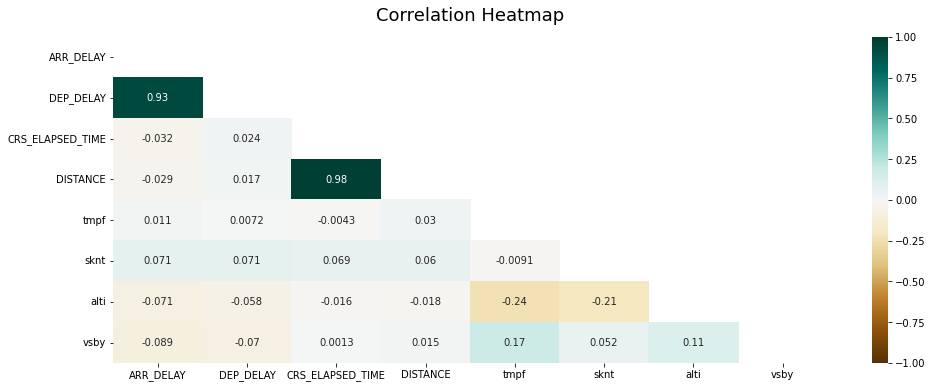

<Figure size 1152x432 with 0 Axes>

In [394]:
#cria a matriz de correlação antes da normalização e exclusão de algumas colunas, com isso decidimos excluir as colunas DEP_DELAY e CRS_ELAPSED TIME

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

dataframe = numeric_features_df.select("ARR_DELAY", "DEP_DELAY","CRS_ELAPSED_TIME", "DISTANCE", "tmpf", \
                           "sknt", "alti", "vsby").toPandas()

# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(dataframe.corr(), dtype=np.bool))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(dataframe.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

plt.figure(figsize=(16, 6))

## Delete Columns

In [395]:
#Deletar colunas que não foram utilizadas

cols = ("OP_CARRIER_FL_NUM","CRS_ARR_TIME","ARR_TIME","WHEELS_ON","WHEELS_OFF","DIVERTED","CANCELLED","CANCELLATION_CODE","ACTUAL_ELAPSED_TIME","AIR_TIME","DEP_TIME",
        "CRS_DEP_TIME",'CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY',"data","hora","station","DEP_DELAY","TAXI_IN")

df=df.drop(*cols).cache()

In [396]:
df.columns

['FL_DATE',
 'OP_CARRIER',
 'ORIGIN',
 'DEST',
 'TAXI_OUT',
 'ARR_DELAY',
 'CRS_ELAPSED_TIME',
 'DISTANCE',
 'CRS_DEP_TIME_hour',
 'DEP_TIME_hour',
 'CRS_ARR_TIME_hour',
 'WEEK_DAY',
 'MONTH',
 'tmpf',
 'sknt',
 'alti',
 'vsby']

In [397]:
#dropar nulls restantes
df=df.dropna().na.drop("all")

In [398]:
count_missings(df)

,count
TAXI_OUT,0
ARR_DELAY,0
CRS_ELAPSED_TIME,0
DISTANCE,0
CRS_DEP_TIME_hour,0
DEP_TIME_hour,0
CRS_ARR_TIME_hour,0
WEEK_DAY,0
MONTH,0
tmpf,0


## Data normalization

In [399]:
from pyspark.sql.functions import *

# Faz as normalizações necessárias

#df_2 = df.withColumn("DEP_DELAY", log(df.DEP_DELAY+1-df.select("DEP_DELAY").rdd.min()[0]))
#df_2 = df.withColumn("TAXI_OUT", log(df.TAXI_OUT+1-df.select("TAXI_OUT").rdd.min()[0]))
#df_2 = df_2.withColumn("TAXI_IN", log(df_2.TAXI_IN+1-df_2.select("TAXI_IN").rdd.min()[0]))
#df_2 = df_2.withColumn("ARR_DELAY", log(df_2.ARR_DELAY+1-df_2.select("ARR_DELAY").rdd.min()[0]))
df_2 = df.withColumn("CRS_ELAPSED_TIME", log(df.CRS_ELAPSED_TIME+1-df.select("CRS_ELAPSED_TIME").rdd.min()[0]))
df_2 = df_2.withColumn("DISTANCE", log(df_2.DISTANCE+1-df.select("DISTANCE").rdd.min()[0]))
df_2 = df_2.withColumn("tmpf", (df_2.tmpf - df_2.select("tmpf").rdd.min()[0])/(df_2.select("tmpf").rdd.max()[0] - df_2.select("tmpf").rdd.min()[0]))
df_2 = df_2.withColumn("sknt", (df_2.sknt - df_2.select("sknt").rdd.min()[0])/(df_2.select("sknt").rdd.max()[0] - df_2.select("sknt").rdd.min()[0]))
df_2 = df_2.withColumn("alti", (df_2.alti - df_2.select("alti").rdd.min()[0])/(df_2.select("alti").rdd.max()[0] - df_2.select("alti").rdd.min()[0]))                    
df_2 = df_2.withColumn("vsby", (df_2.vsby - df_2.select("vsby").rdd.min()[0])/(df_2.select("vsby").rdd.max()[0] - df_2.select("vsby").rdd.min()[0]))

In [400]:
df_2 = df_2.withColumn("alti", (df_2.alti - df_2.select("alti").rdd.min()[0])/(df_2.select("alti").rdd.max()[0] - df_2.select("alti").rdd.min()[0]))

In [401]:
df_2 = df_2.withColumn("vsby", (df_2.vsby - df_2.select("vsby").rdd.min()[0])/(df_2.select("vsby").rdd.max()[0] - df_2.select("vsby").rdd.min()[0]))

In [402]:
df_2.limit(5).toPandas()

,FL_DATE,OP_CARRIER,ORIGIN,DEST,TAXI_OUT,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_TIME_hour,DEP_TIME_hour,CRS_ARR_TIME_hour,WEEK_DAY,MONTH,tmpf,sknt,alti,vsby
0,2009-06-22,WN,BDL,MDW,13.0,-17.0,4.744932,6.602588,17,17,17,2,6,0.721080,0.270270,0.396040,0.133333
1,2013-08-09,US,BDL,CLT,13.0,-5.0,4.543295,6.403574,10,10,10,6,8,0.745501,0.216216,0.564356,0.093333
2,2014-06-07,EV,BGR,LGA,12.0,114.0,4.143135,5.823046,9,9,9,7,6,0.628535,0.162162,0.485148,0.133333
3,2015-05-16,OO,BHM,ORD,17.0,11.0,4.532599,6.298949,9,9,9,7,5,0.714653,0.162162,0.663366,0.133333
4,2010-07-09,WN,BOI,GEG,8.0,22.0,3.401197,5.509388,16,16,17,6,7,0.813625,0.081081,0.603961,0.133333


In [403]:
count_missings(df_2)

,count
TAXI_OUT,0
ARR_DELAY,0
CRS_ELAPSED_TIME,0
DISTANCE,0
CRS_DEP_TIME_hour,0
DEP_TIME_hour,0
CRS_ARR_TIME_hour,0
WEEK_DAY,0
MONTH,0
tmpf,0


In [404]:
#cria a coluna com a multiplicação dos fatores meteorológicos

df_2 = df_2.withColumn("Fator_Clima", ((1+df_2.tmpf) * (1+df_2.sknt) * (1+df_2.alti) * (1+df_2.vsby)-1))

df_2.limit(5).toPandas()

,FL_DATE,OP_CARRIER,ORIGIN,DEST,TAXI_OUT,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_TIME_hour,DEP_TIME_hour,CRS_ARR_TIME_hour,WEEK_DAY,MONTH,tmpf,sknt,alti,vsby,Fator_Clima
0,2009-06-22,WN,BDL,MDW,13.0,-17.0,4.744932,6.602588,17,17,17,2,6,0.721080,0.270270,0.396040,0.133333,2.459017
1,2013-08-09,US,BDL,CLT,13.0,-5.0,4.543295,6.403574,10,10,10,6,8,0.745501,0.216216,0.564356,0.093333,2.630941
2,2014-06-07,EV,BGR,LGA,12.0,114.0,4.143135,5.823046,9,9,9,7,6,0.628535,0.162162,0.485148,0.133333,2.185600
3,2015-05-16,OO,BHM,ORD,17.0,11.0,4.532599,6.298949,9,9,9,7,5,0.714653,0.162162,0.663366,0.133333,2.756544
4,2010-07-09,WN,BOI,GEG,8.0,22.0,3.401197,5.509388,16,16,17,6,7,0.813625,0.081081,0.603961,0.133333,2.564159


In [405]:
df3=df_2

In [406]:
#transformar ARR_DELAY, atrasos acima de 0 minutos já serão considerados atrasos (sem tolerância)
df_2=df_2.withColumn('ARR_DELAY', f.when(df_2['ARR_DELAY']>0,1.00)
                          .otherwise(0.00)).cache()

In [407]:
df_2.select('ARR_DELAY').describe().toPandas()

,summary,ARR_DELAY
0,count,18974
1,mean,0.39148308211236427
2,stddev,0.48809490315330406
3,min,0.0
4,max,1.0


## Exploratory data analysis

In [408]:
df_2.toPandas()

,FL_DATE,OP_CARRIER,ORIGIN,DEST,TAXI_OUT,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_TIME_hour,DEP_TIME_hour,CRS_ARR_TIME_hour,WEEK_DAY,MONTH,tmpf,sknt,alti,vsby,Fator_Clima
0,2009-06-22,WN,BDL,MDW,13.0,0.0,4.744932,6.602588,17,17,17,2,6,0.721080,0.270270,0.396040,0.133333,2.459017
1,2013-08-09,US,BDL,CLT,13.0,0.0,4.543295,6.403574,10,10,10,6,8,0.745501,0.216216,0.564356,0.093333,2.630941
2,2014-06-07,EV,BGR,LGA,12.0,1.0,4.143135,5.823046,9,9,9,7,6,0.628535,0.162162,0.485148,0.133333,2.185600
3,2015-05-16,OO,BHM,ORD,17.0,1.0,4.532599,6.298949,9,9,9,7,5,0.714653,0.162162,0.663366,0.133333,2.756544
4,2010-07-09,WN,BOI,GEG,8.0,1.0,3.401197,5.509388,16,16,17,6,7,0.813625,0.081081,0.603961,0.133333,2.564159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18969,2010-03-31,DL,KOA,LAX,14.0,1.0,5.676754,7.809541,20,20,20,4,3,0.799486,0.270270,0.623762,0.133333,3.206537
18970,2010-05-30,UA,KOA,SFO,11.0,0.0,5.634790,7.752335,12,12,12,1,5,0.721080,0.108108,0.608911,0.133333,2.477544
18971,2010-08-19,UA,KOA,SFO,15.0,0.0,5.613128,7.752335,20,20,21,5,8,0.796915,0.243243,0.599010,0.133333,3.048486
18972,2015-07-31,AS,KOA,SEA,11.0,1.0,5.746203,7.881560,22,22,22,6,7,0.843188,0.270270,0.549505,0.133333,3.111652


In [409]:
df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME_hour: integer (nullable = true)
 |-- DEP_TIME_hour: integer (nullable = true)
 |-- CRS_ARR_TIME_hour: integer (nullable = true)
 |-- WEEK_DAY: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- tmpf: float (nullable = true)
 |-- sknt: float (nullable = true)
 |-- alti: float (nullable = true)
 |-- vsby: float (nullable = true)



In [410]:
df_2.describe().toPandas()

,summary,OP_CARRIER,ORIGIN,DEST,TAXI_OUT,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_TIME_hour,DEP_TIME_hour,CRS_ARR_TIME_hour,WEEK_DAY,MONTH,tmpf,sknt,alti,vsby,Fator_Clima
0,count,18974,18974,18974,18974,18974,18974,18974,18974,18974,18974,18974,18974,18974,18974,18974,18974,18974
1,mean,None,None,None,15.977759038684516,0.39148308211236427,4.384686797255066,6.236334449366482,12.984452408559081,12.984452408559081,13.112627806472014,3.949246337092864,6.328185938652894,0.6374344072977841,0.20047062979496932,0.598657952240244,0.1219425108042233,2.5185380094230982
2,stddev,None,None,None,9.919574904421124,0.48809490315330406,0.7335802482950654,0.8455461983122989,4.615680568810401,4.615680568810401,4.63567704089143,1.9461214290462647,3.4351740745359343,0.14313074732773692,0.13205430675768454,0.09810629395836838,0.029506736707608124,0.49670891259031075
3,min,9E,BDL,ABE,1.0,0.0,0.0,0.0,0,0,0,1,1,0.0,0.0,0.0,0.0,0.5992261795757714
4,max,YX,USA,YAK,158.0,1.0,6.476972362889683,8.505727713306959,23,23,24,7,12,1.0,1.0,1.0,1.0,4.908764541972613


In [411]:
import matplotlib.pyplot as plt
import seaborn as sns

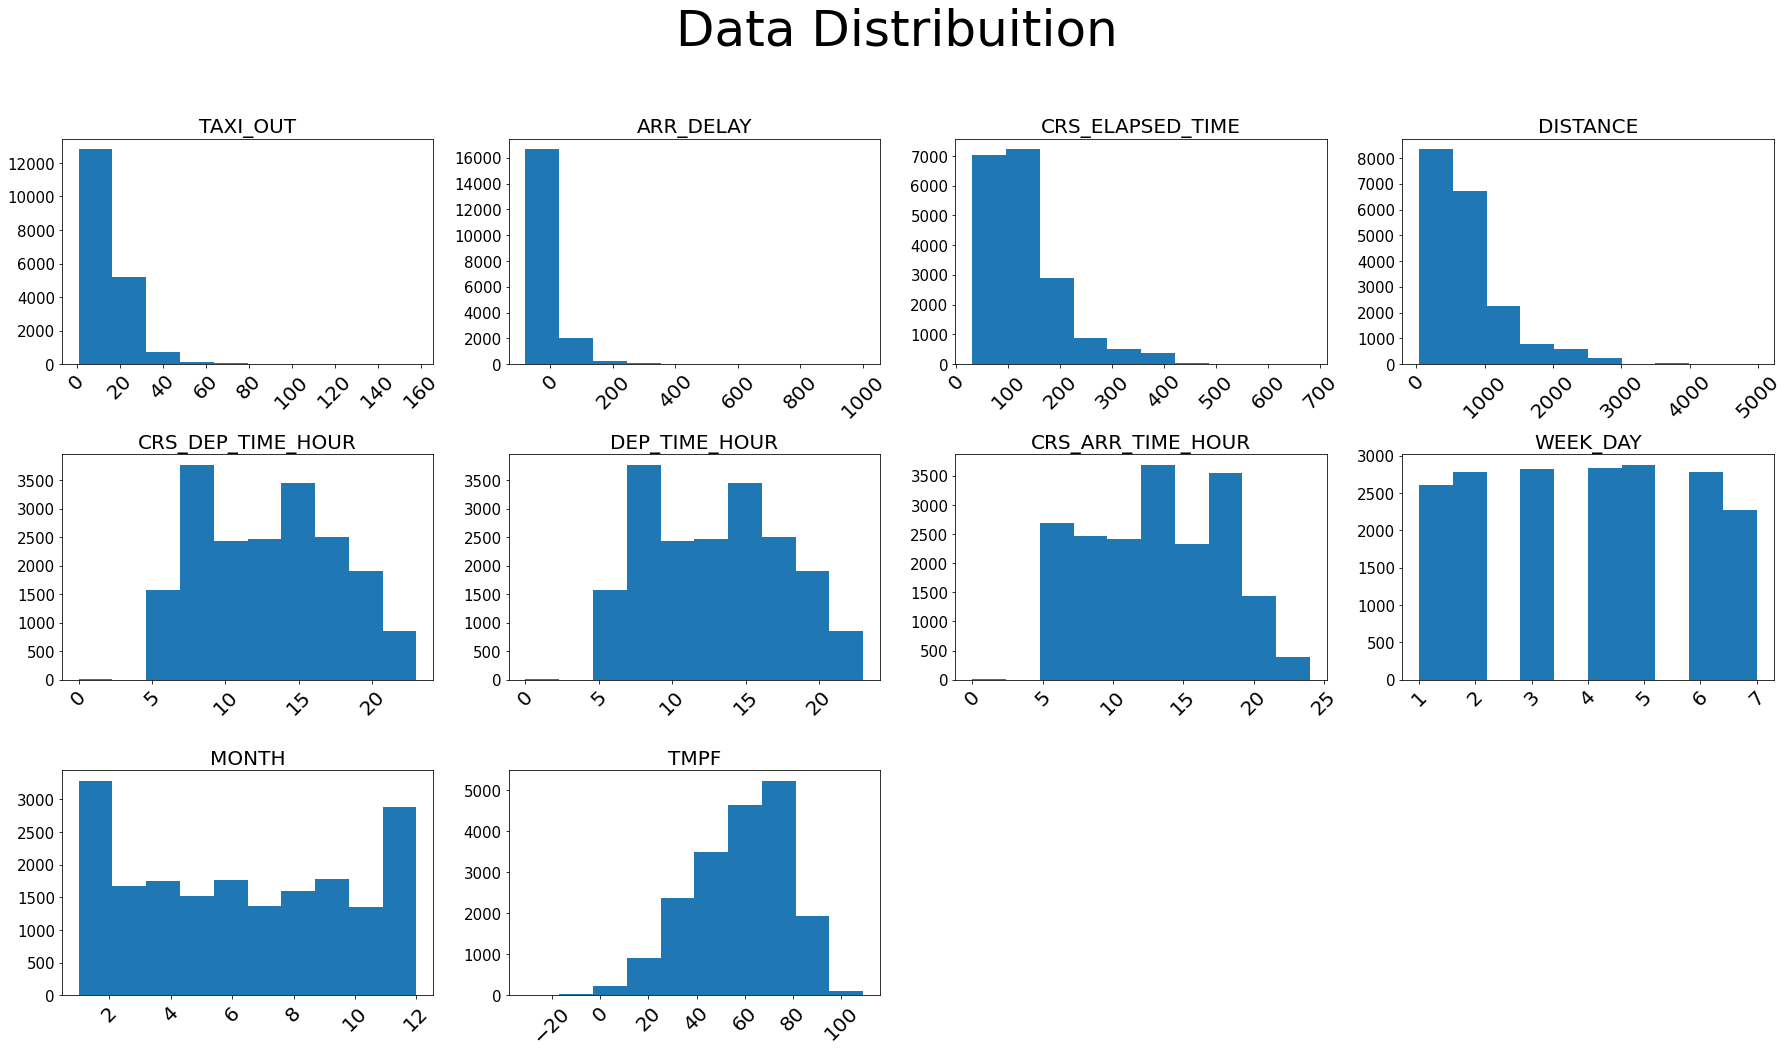

In [412]:
#Checar distribuição de dados antes da normalização
fig=plt.figure(figsize=(25,15))
st=fig.suptitle("Data Distribuition", fontsize=50, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1,11)):
    ax=fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
    
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

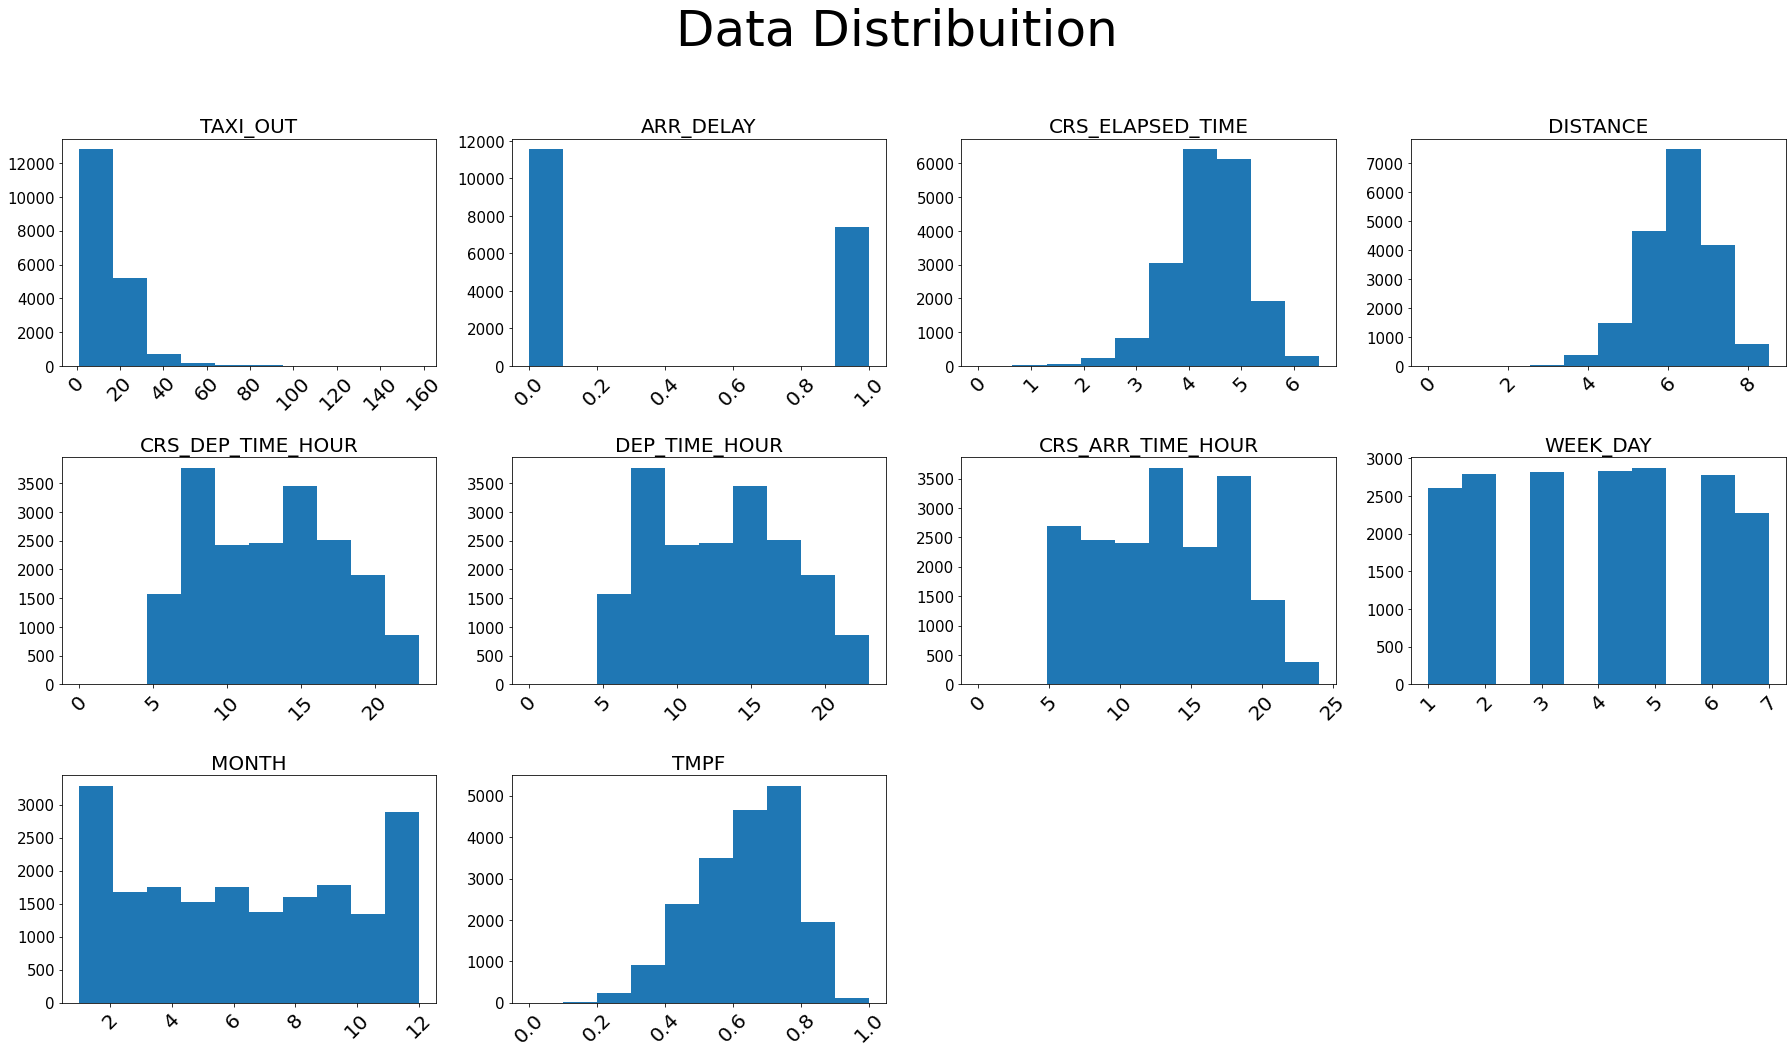

In [413]:
#Checar distribuição de dados após a normalização
fig=plt.figure(figsize=(25,15))
st=fig.suptitle("Data Distribuition", fontsize=50, verticalalignment="center")
for col, num in zip(df_2.toPandas().describe().columns, range(1,11)):
    ax=fig.add_subplot(3,4,num)
    ax.hist(df_2.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
    
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

### Correlation post normalization

In [414]:
numeric_features=[t[0] for t in df_2.dtypes if t[1] !='string']
del numeric_features[0]
numeric_features_df=df_2.select(numeric_features)
numeric_features_df.toPandas().head()

,TAXI_OUT,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_TIME_hour,DEP_TIME_hour,CRS_ARR_TIME_hour,WEEK_DAY,MONTH,tmpf,sknt,alti,vsby,Fator_Clima
0,13.0,0.0,4.744932,6.602588,17,17,17,2,6,0.721080,0.270270,0.396040,0.133333,2.459017
1,13.0,0.0,4.543295,6.403574,10,10,10,6,8,0.745501,0.216216,0.564356,0.093333,2.630941
2,12.0,1.0,4.143135,5.823046,9,9,9,7,6,0.628535,0.162162,0.485148,0.133333,2.185600
3,17.0,1.0,4.532599,6.298949,9,9,9,7,5,0.714653,0.162162,0.663366,0.133333,2.756544
4,8.0,1.0,3.401197,5.509388,16,16,17,6,7,0.813625,0.081081,0.603961,0.133333,2.564159


In [415]:
col_names=numeric_features_df.columns
features=numeric_features_df.rdd.map(lambda row: row[0:])

In [416]:
from pyspark.mllib.stat import Statistics
import pandas as pd

In [417]:
corr_mat=Statistics.corr(features, method="pearson")
corr_df=pd.DataFrame(corr_mat)
corr_df.index=col_names
corr_df.columns=col_names
corr_df

,TAXI_OUT,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_TIME_hour,DEP_TIME_hour,CRS_ARR_TIME_hour,WEEK_DAY,MONTH,tmpf,sknt,alti,vsby,Fator_Clima
TAXI_OUT,1.000000,0.290091,0.148243,0.079881,0.027280,0.027280,0.027046,0.000288,-0.033601,-0.061162,0.083976,-0.052912,-0.110124,-0.018448
ARR_DELAY,0.290091,1.000000,-0.004102,0.006976,0.132264,0.132264,0.132157,-0.006492,-0.028724,0.003006,0.075815,-0.070836,-0.079169,0.014967
CRS_ELAPSED_TIME,0.148243,-0.004102,1.000000,0.958043,-0.008454,-0.008454,-0.007832,0.013616,-0.014338,-0.044140,0.055465,-0.005364,-0.009809,0.009139
DISTANCE,0.079881,0.006976,0.958043,1.000000,-0.003065,-0.003065,-0.002556,0.016760,-0.007519,0.003729,0.049416,-0.008547,0.009578,0.037768
CRS_DEP_TIME_hour,0.027280,0.132264,-0.008454,-0.003065,1.000000,1.000000,0.997398,-0.034765,-0.005116,0.251223,0.251431,-0.014548,0.060851,0.359513
DEP_TIME_hour,0.027280,0.132264,-0.008454,-0.003065,1.000000,1.000000,0.997398,-0.034765,-0.005116,0.251223,0.251431,-0.014548,0.060851,0.359513
CRS_ARR_TIME_hour,0.027046,0.132157,-0.007832,-0.002556,0.997398,0.997398,1.000000,-0.034811,-0.004281,0.250024,0.251118,-0.014871,0.059459,0.358182
WEEK_DAY,0.000288,-0.006492,0.013616,0.016760,-0.034765,-0.034765,-0.034811,1.000000,-0.020679,-0.015118,-0.008819,0.010984,0.004715,-0.010049
MONTH,-0.033601,-0.028724,-0.014338,-0.007519,-0.005116,-0.005116,-0.004281,-0.020679,1.000000,0.238180,-0.078067,0.007267,0.038787,0.099495
tmpf,-0.061162,0.003006,-0.044140,0.003729,0.251223,0.251223,0.250024,-0.015118,0.238180,1.000000,-0.009075,-0.238500,0.173185,0.553286


<Figure size 1152x432 with 0 Axes>

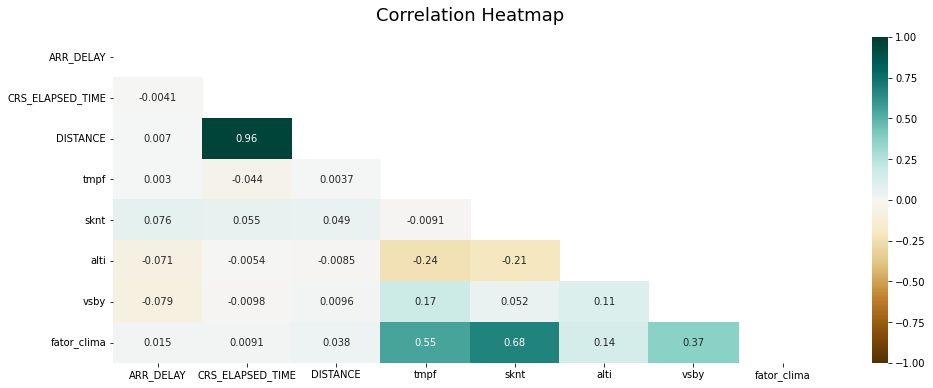

<Figure size 1152x432 with 0 Axes>

In [418]:
#cria a matriz de correlação após a normalização dos dados, excluir CRS_ELAPSED_TIME

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

dataframe = df_2.select("ARR_DELAY", "CRS_ELAPSED_TIME", "DISTANCE", "tmpf", \
                           "sknt", "alti", "vsby", "fator_clima").toPandas()

# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(dataframe.corr(), dtype=np.bool))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(dataframe.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

plt.figure(figsize=(16, 6))

In [419]:
df_2.groupby("ARR_DELAY").count().toPandas()

,ARR_DELAY,count
0,0.0,11546
1,1.0,7428


## Train/Test Split

* [pyspark.sql.DataFrame.randomSplit](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.randomSplit.html)
* [pyspark.sql.DataFrame.sample](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.sample.html)

In [420]:
train_df, test_df = df_2.randomSplit([0.5, 0.5], seed=42)
toy_df = test_df #.sample(False, 0.01, seed=42)

In [421]:
#print("Train set count: ", train_df.count())
#print("Test set count:", test_df.count())
#print("Toy df count:", toy_df.count())

## Feature Engineering: One-Hot-Encoding

* [pyspark.ml.feature.StringIndexer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html)
* [pyspark.ml.feature.OneHotEncoder](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.feature.OneHotEncoder.html)

In [422]:
cat_feats = ["OP_CARRIER","ORIGIN","DEST","CRS_DEP_TIME_hour","CRS_ARR_TIME_hour","WEEK_DAY","MONTH"]

indexOutputCols = [x + "Index" for x in cat_feats]
oheOutputCols = [x + "OHE" for x in cat_feats]

stringIndexer = StringIndexer(inputCols = cat_feats,
                              outputCols = indexOutputCols,
                              handleInvalid = "skip")

oheEncoder = OneHotEncoder(inputCols = indexOutputCols, outputCols = oheOutputCols )

## Feature Engineering: Feature Normalization

* [pyspark.ml.feature.VectorAssembler](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html)
* [pyspark.ml.feature.StandardScaler](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StandardScaler.html)

In [423]:
num_feats = ["CRS_ELAPSED_TIME","sknt","vsby","TAXI_OUT"]

numVecAssembler = VectorAssembler(inputCols = num_feats, outputCol = "features", handleInvalid='skip')

stdScaler = StandardScaler(inputCol='features', outputCol='features_scaled')

## Assembling dos vetores

In [424]:
assemblerInputs = oheOutputCols + ['features_scaled']

vecAssembler = VectorAssembler(inputCols = assemblerInputs, outputCol = "features_vector")

In [425]:
stages = [stringIndexer, oheEncoder, numVecAssembler, stdScaler, vecAssembler]

## Visualizando as transformações

In [426]:
transform_pipeline =  Pipeline(stages=stages)
fitted_transformer = transform_pipeline.fit(train_df)
transformed_train_df = fitted_transformer.transform(train_df)
#transformed_train_df.limit(10).toPandas()

## Criação do Pipeline

* [pyspark.ml.regression.LogisticRegression](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LogisticRegression.html)
* [pyspark.ml.Pipeline](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Pipeline.html)

In [427]:
from pyspark.ml.classification import LogisticRegression

model=LogisticRegression(maxIter=50, 
                         regParam=0.02, 
                         elasticNetParam=0.2,
                         labelCol='ARR_DELAY', 
                         featuresCol='features_vector')

pipe_stages = stages + [model]

pipe = Pipeline(stages=pipe_stages)

## Model Training

In [428]:
fitted_pipe = pipe.fit(train_df)

## Model performance evaluation

* [pyspark.ml.evaluation.BinaryClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html)

In [429]:
preds = fitted_pipe.transform(test_df)

In [430]:
preds.count()

9515

In [431]:
preds.limit(10).toPandas()

,FL_DATE,OP_CARRIER,ORIGIN,DEST,TAXI_OUT,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_TIME_hour,DEP_TIME_hour,...,CRS_DEP_TIME_hourOHE,ORIGINOHE,WEEK_DAYOHE,MONTHOHE,features,features_scaled,features_vector,rawPrediction,probability,prediction
0,2009-01-01,B6,BOS,FLL,15.0,1.0,5.147494,7.087574,18,18,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.147494476813453, 0.4864864864864865, 0.1333...","[6.9903561436024475, 3.6614509870866057, 4.428...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.23992513631911194, -0.23992513631911194]","[0.5596952002074226, 0.4403047997925774]",0.0
1,2009-01-04,B6,BOS,PBI,13.0,1.0,5.099866,7.053586,20,20,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.099866427824199, 0.21621621621621623, 0.133...","[6.925676710460844, 1.6273115498162691, 4.4287...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.17119484083371406, -0.17119484083371406]","[0.542694488096354, 0.45730551190364593]",0.0
2,2009-01-04,FL,BWI,ATL,16.0,1.0,4.430817,6.284134,10,10,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.430816798843313, 0.0, 0.13333333333333333, ...","[6.01709969199327, 0.0, 4.428715090363119, 1.6...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5672824648183488, -0.5672824648183488]","[0.6381358819255418, 0.36186411807445823]",0.0
3,2009-01-04,US,BOS,DCA,16.0,0.0,4.158883,5.883322,15,15,...,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.1588830833596715, 0.3783783783783784, 0.133...","[5.6478106082951225, 2.847795212178471, 4.4287...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.4090466968375046, -0.4090466968375046]","[0.6008592726203821, 0.399140727379618]",0.0
4,2009-01-06,DL,BOS,LGA,16.0,0.0,3.784190,4.976734,14,14,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.784189633918261, 0.24324324324324326, 0.133...","[5.138972635166923, 1.8307254935433028, 4.4287...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.4336750468580486, -0.4336750468580486]","[0.6067508933799262, 0.39324910662007384]",0.0
5,2009-01-07,WN,BNA,BHM,8.0,0.0,2.995732,4.919981,9,9,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.995732273553991, 0.24324324324324326, 0.093...","[4.068238557098929, 1.8307254935433028, 3.1001...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.48593877678027086, -0.48593877678027086]","[0.619149246357809, 0.38085075364219106]",0.0
6,2009-01-12,OO,BOI,SFO,9.0,0.0,4.317488,6.177944,17,17,...,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.31748811353631, 0.0, 0.12, 9.0]","[5.863198046221595, 0.0, 3.9858435813268076, 0...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.7253554636923201, -0.7253554636923201]","[0.6737852347351464, 0.32621476526485355]",0.0
7,2009-01-12,US,BOS,LGA,16.0,0.0,3.761200,4.976734,16,16,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.7612001156935624, 0.243243243243243

In [432]:
df_2.select('ARR_DELAY').describe().toPandas()

,summary,ARR_DELAY
0,count,18974
1,mean,0.39148308211236427
2,stddev,0.48809490315330406
3,min,0.0
4,max,1.0


In [433]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(labelCol="ARR_DELAY",metricName="areaUnderROC").evaluate(preds)
print('AreaUnderRoc on test set:', evaluator)
#rmse = RegressionEvaluator(labelCol='ARR_DELAY', metricName='rmse').evaluate(preds)
#print('RMSE of Prediction on test set:', rmse)

AreaUnderRoc on test set: 0.7024388848180328


In [434]:
# Fit the model
fitted_pipe.stages[-1].coefficients

SparseVector(484, {0: 0.3168, 1: -0.048, 3: -0.21, 4: 0.1356, 5: 0.0019, 6: -0.2221, 7: -0.1742, 10: -0.1078, 11: -0.0385, 14: -0.2098, 15: 0.4127, 19: 0.0564, 22: 0.071, 25: -0.3859, 26: -0.4165, 30: -0.9191, 32: -0.2911, 35: 0.3793, 36: 0.3315, 38: 0.2305, 40: -0.223, 43: 0.0558, 44: 0.0395, 47: 0.0513, 48: -0.4001, 52: -0.0034, 56: 0.2648, 58: -0.1431, 62: 0.2162, 63: 0.0971, 64: -0.1867, 65: -0.0368, 67: -0.1205, 70: 0.2588, 71: -0.2536, 72: 0.1795, 74: 0.2465, 77: 0.2158, 80: -0.989, 82: 0.2324, 83: -0.1096, 85: -0.6219, 93: 0.2999, 95: 0.2818, 97: -0.0066, 99: 0.0, 101: -0.2024, 102: 0.4633, 105: -0.0328, 106: 0.0914, 113: 1.299, 122: -1.026, 123: 0.8669, 127: -0.437, 130: 0.9466, 132: -0.7844, 135: -0.0306, 136: 0.2766, 137: -0.5326, 142: -0.1657, 143: -0.4519, 144: 1.5949, 146: 0.4821, 147: -0.2544, 149: -0.5268, 151: 0.0026, 158: -0.3738, 160: 0.625, 161: 1.1235, 163: 0.994, 168: 1.1725, 172: -0.0721, 173: 0.0329, 177: 0.0037, 179: -0.0444, 180: -0.0015, 181: 0.0064, 184: -0.0

## Hyperparameter Tuning

* [pyspark.ml.tuning.ParamGridBuilder](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html)
* [pyspark.ml.tuning.CrossValidator](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html)

In [435]:
parameter_grid = ParamGridBuilder() \
                 .addGrid(model.elasticNetParam, [0.2, 0.3]) \
                 .addGrid(model.regParam, [0.02, 0.03]) \
                 .build()

cross_val = CrossValidator(estimator=pipe,
                           estimatorParamMaps=parameter_grid,
                           evaluator=BinaryClassificationEvaluator(labelCol='ARR_DELAY'), 
                           numFolds=5)
    
cv_model = cross_val.fit(toy_df)

In [436]:
en = [0.2, 0.3]
reg = [0.02, 0.03]
elastic_net = [e for e in en for r in reg]
regularization = [r for e in en for r in reg]

roc_df = pd.DataFrame({'areaUnderROC':cv_model.avgMetrics,
                        'elastic_net_alpha': elastic_net, 
                        'regularization_term': regularization})

roc_df.sort_values(by='areaUnderROC')

,areaUnderROC,elastic_net_alpha,regularization_term
0,0.699744,0.2,0.02
3,0.702036,0.3,0.03
1,0.702355,0.2,0.03
2,0.702973,0.3,0.02


# RANDOM FOREST: Otimização de hiperparâmetros e Validação Cruzada

Vamos construir um modelo para nosso problema em questão agora fazendo uso de um `RandomForestClassifier`. Vamos querer otimizar 2 hiperparâmetros (`maxDepth` e `numTrees`), e obter seus valores a partir de um processo de validação cruzada com 5-folds.

In [437]:
from pyspark.ml.classification import RandomForestClassifier
#from pyspark.ml.regression import RandomForestRegressor

In [438]:
#rf= RandomForestRegressor(labelCol="ARR_DELAY", seed=42)
rf = RandomForestClassifier(labelCol='ARR_DELAY', featuresCol='features', numTrees=10)

In [439]:
pipeline_rf=Pipeline(stages=[stringIndexer,oheEncoder,numVecAssembler, stdScaler, rf])

In [440]:
fitted_pipe = pipeline_rf.fit(train_df)

In [441]:
preds = fitted_pipe.transform(test_df)

In [442]:
preds.limit(10).toPandas()

,FL_DATE,OP_CARRIER,ORIGIN,DEST,TAXI_OUT,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_TIME_hour,DEP_TIME_hour,...,OP_CARRIEROHE,CRS_DEP_TIME_hourOHE,ORIGINOHE,WEEK_DAYOHE,MONTHOHE,features,features_scaled,rawPrediction,probability,prediction
0,2009-01-01,B6,BOS,FLL,15.0,1.0,5.147494,7.087574,18,18,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.147494476813453, 0.4864864864864865, 0.1333...","[6.9903561436024475, 3.6614509870866057, 4.428...","[6.038881801579792, 3.9611181984202077]","[0.6038881801579792, 0.39611181984202076]",0.0
1,2009-01-04,B6,BOS,PBI,13.0,1.0,5.099866,7.053586,20,20,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.099866427824199, 0.21621621621621623, 0.133...","[6.925676710460844, 1.6273115498162691, 4.4287...","[6.752317565279477, 3.2476824347205215]","[0.6752317565279479, 0.3247682434720522]",0.0
2,2009-01-04,FL,BWI,ATL,16.0,1.0,4.430817,6.284134,10,10,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.430816798843313, 0.0, 0.13333333333333333, ...","[6.01709969199327, 0.0, 4.428715090363119, 1.6...","[6.716268490444956, 3.2837315095550426]","[0.6716268490444958, 0.3283731509555043]",0.0
3,2009-01-04,US,BOS,DCA,16.0,0.0,4.158883,5.883322,15,15,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.1588830833596715, 0.3783783783783784, 0.133...","[5.6478106082951225, 2.847795212178471, 4.4287...","[6.371470369526394, 3.628529630473605]","[0.6371470369526394, 0.36285296304736053]",0.0
4,2009-01-06,DL,BOS,LGA,16.0,0.0,3.784190,4.976734,14,14,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.784189633918261, 0.24324324324324326, 0.133...","[5.138972635166923, 1.8307254935433028, 4.4287...","[6.709282441923334, 3.2907175580766648]","[0.6709282441923334, 0.32907175580766646]",0.0
5,2009-01-07,WN,BNA,BHM,8.0,0.0,2.995732,4.919981,9,9,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.995732273553991, 0.24324324324324326, 0.093...","[4.068238557098929, 1.8307254935433028, 3.1001...","[6.683872124226653, 3.316127875773346]","[0.6683872124226653, 0.3316127875773346]",0.0
6,2009-01-12,OO,BOI,SFO,9.0,0.0,4.317488,6.177944,17,17,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.31748811353631, 0.0, 0.12, 9.0]","[5.863198046221595, 0.0, 3.9858435813268076, 0...","[6.990164165041303, 3.0098358349586958]","[0.6990164165041304, 0.30098358349586957]",0.0
7,2009-01-12,US,BOS,LGA,16.0,0.0,3.761200,4.976734,16,16,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.76120

Olhando a documentação vc consegue escolher quais parâmetros usar para cada modelo diferente

In [454]:
paramGrid=(ParamGridBuilder()
          .addGrid(rf.maxDepth,[2,6])
          .addGrid(rf.numTrees,[10,50])
          .build())

E criamos também um `BinaryClassificationEvaluator`

In [455]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(labelCol="ARR_DELAY",metricName="areaUnderROC").evaluate(preds)

In [456]:
preds

DataFrame[FL_DATE: date, OP_CARRIER: string, ORIGIN: string, DEST: string, TAXI_OUT: double, ARR_DELAY: double, CRS_ELAPSED_TIME: double, DISTANCE: double, CRS_DEP_TIME_hour: int, DEP_TIME_hour: int, CRS_ARR_TIME_hour: int, WEEK_DAY: int, MONTH: int, tmpf: double, sknt: double, alti: double, vsby: double, Fator_Clima: double, ORIGINIndex: double, WEEK_DAYIndex: double, MONTHIndex: double, DESTIndex: double, OP_CARRIERIndex: double, CRS_ARR_TIME_hourIndex: double, CRS_DEP_TIME_hourIndex: double, DESTOHE: vector, CRS_ARR_TIME_hourOHE: vector, OP_CARRIEROHE: vector, CRS_DEP_TIME_hourOHE: vector, ORIGINOHE: vector, WEEK_DAYOHE: vector, MONTHOHE: vector, features: vector, features_scaled: vector, rawPrediction: vector, probability: vector, prediction: double]

Para executar a validação cruzada, nós precisamos importar a função `CrossValidator` de `pyspark.ml.tuning`.

In [457]:
cross_val = CrossValidator(estimator=pipeline_rf,
                           estimatorParamMaps=parameter_grid,
                           evaluator=BinaryClassificationEvaluator(labelCol='ARR_DELAY'), 
                           numFolds=5)

cv_model = cross_val.fit(toy_df)

E podemos obter nosso modelo a partir do `fit`.

In [458]:
maxDepth = [2,6]
numTrees = [10, 50]
Depth = [e for e in maxDepth for r in numTrees]
numTrees = [r for e in maxDepth for r in numTrees]

roc_df = pd.DataFrame({'areaUnderROC:':cv_model.avgMetrics,
                        'maxDepth': Depth, 
                        'numTrees': numTrees})

roc_df.sort_values(by='areaUnderROC:')

,areaUnderROC:,maxDepth,numTrees
0,0.655465,2,10
1,0.655465,2,50
2,0.655465,6,10
3,0.655465,6,50


## ROC AUC da RANDOM FOREST

In [448]:
pred_pd = preds.select(['ARR_DELAY', 'prediction', 'probability']).toPandas()

In [449]:
pred_pd

,ARR_DELAY,prediction,probability
0,1.0,0.0,"[0.6038881801579792, 0.39611181984202076]"
1,1.0,0.0,"[0.6752317565279479, 0.3247682434720522]"
2,1.0,0.0,"[0.6716268490444958, 0.3283731509555043]"
3,0.0,0.0,"[0.6371470369526394, 0.36285296304736053]"
4,0.0,0.0,"[0.6709282441923334, 0.32907175580766646]"
...,...,...,...
9510,0.0,0.0,"[0.6962703181324092, 0.3037296818675907]"
9511,0.0,1.0,"[0.3924176904288454, 0.6075823095711546]"
9512,1.0,1.0,"[0.11070883799000686, 0.8892911620099931]"
9513,0.0,1.0,"[0.3109739849243103, 0.6890260150756897]"


We need to convert the column prediction into a list, because now it is of type VectorDense. We will create a new column encoded_label that we will use to plot the roc curve.

In [450]:
import numpy as np
pred_pd['probability'] = pred_pd['probability'].map(lambda x: list(x))
pred_pd['encoded_label'] = pred_pd['ARR_DELAY'].map(lambda x: np.eye(2)[int(x)])

In [451]:
y_pred = np.array(pred_pd['probability'].tolist())
y_true = np.array(pred_pd['encoded_label'].tolist())

In [452]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, threshold = roc_curve(y_score=y_pred[:,0], y_true=y_true[:,0])
auc = auc(fpr, tpr)

print('AUC: {:.8f}'.format(auc))

AUC: 0.65383644


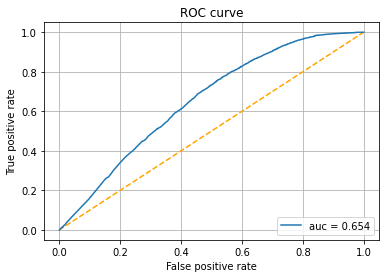

In [453]:
plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()